In [2]:
torch

NameError: name 'torch' is not defined

In [15]:
!pip3 install pandas tqdm seaborn scikit-learn plotly

  Using cached plotly-5.14.1-py2.py3-none-any.whl (15.3 MB)
  Using cached tenacity-8.2.2-py3-none-any.whl (24 kB)


You should consider upgrading via the 'c:\users\amatu\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\amatu\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [1]:

!pip3 freeze > req.txt

In [1]:
import glob
import pandas as pd
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:,.2f}'.format
import numpy as np
import tqdm
import os
import plotly.graph_objs as go
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns


c:\Users\amatu\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.__version__

'1.13.1+cu117'

In [4]:
# df = pd.read_csv('../data/nq5years2h.csv')
dfext = pd.read_csv( '../data/nq_ext.csv', skiprows=2, names=['price', 'target'] )

Хорошо бы дать более понятные названия фичам\
Также достроим дельта(VarName2) и return

In [5]:
dfext

,price,target
0,12140,0
1,12145,0
2,12142,0
3,12140,0
4,12131,0
...,...,...
7320,12687,0
7321,12678,0
7322,12678,0
7323,12683,0


In [6]:
!mkdir model

A subdirectory or file model already exists.


In [7]:
destination_folder = './model'

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [9]:
dfext.values

array([[12140,     0],
       [12145,     0],
       [12142,     0],
       ...,
       [12678,     0],
       [12683,     0],
       [12680,     0]], dtype=int64)

<Axes: >

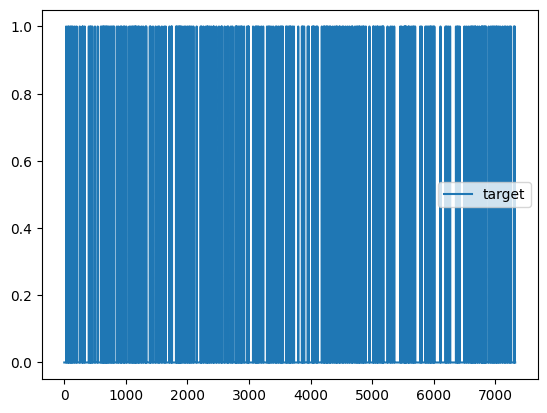

In [10]:
dfext[['target']].plot()

In [11]:
scaler = StandardScaler()
dfext[['scprice']] = scaler.fit_transform(dfext[['price']])

In [12]:
dfext[['price']].values

array([[12140],
       [12145],
       [12142],
       ...,
       [12678],
       [12683],
       [12680]], dtype=int64)

In [13]:
fake_data = np.array(list(range(10)))

In [14]:
fake_data = fake_data.reshape((-1,1))



In [15]:
scaler = MinMaxScaler()
scaler.fit_transform(fake_data).reshape((-1,))

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [16]:
dfext['target'].unique()

array([0, 1], dtype=int64)

<Axes: >

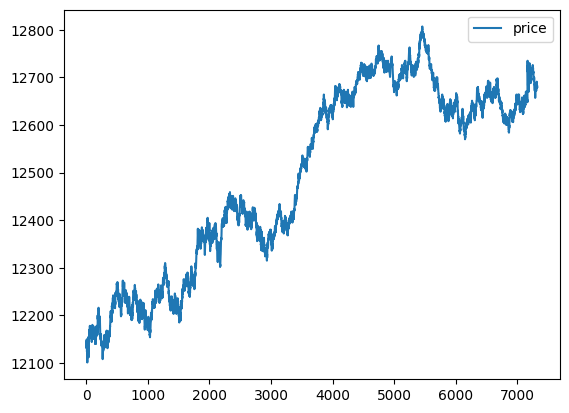

In [17]:
dfext[['price']].plot()

In [18]:
def save_checkpoint(save_path, model, optimizer, valid_loss):
    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [19]:
def create_dataset(dataset, classes, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
            data: A numpy array of time series
         classes: A numpy array with target variable
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback-1):
        feature = dataset[i:i+lookback]
        target = classes[i+lookback]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [20]:
lookback = 15
test_size = 2000

ts_price = dfext[['price']].values.astype('float32')
ts_target = dfext[['target']].values.astype('float32')

train_size = int(len(ts_price) * 0.67)
test_size = len(ts_price) - train_size
train_price, test_price = ts_price[:train_size], ts_price[train_size:]
train_target, test_taget = ts_target[:train_size], ts_target[train_size:]

In [21]:
train_price

array([[12140.],
       [12145.],
       [12142.],
       ...,
       [12720.],
       [12724.],
       [12728.]], dtype=float32)

In [22]:
X_train, y_train = create_dataset(train_price,train_target, lookback=lookback)
X_test, y_test = create_dataset(test_price, test_taget, lookback=lookback)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
# X, Y = create_dataset(dfext.price.values, dfext.target, lookback)

C:\Users\amatu\AppData\Local\Temp\ipykernel_17012\2854856625.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  return torch.tensor(X), torch.tensor(y)


torch.Size([4891, 15, 1]) torch.Size([4891, 1])
torch.Size([2402, 15, 1]) torch.Size([2402, 1])


In [23]:
y_train.shape

torch.Size([4891, 1])

In [24]:
train_loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=64)
test_loader = data.DataLoader(data.TensorDataset(X_test, y_test), shuffle=True, batch_size=64)


In [25]:
class MinMaxClassifier(nn.Module):
    def __init__(self, numer_of_features, hidden_size, num_layers, out_size, lr):
        super().__init__()
        self.lr = lr
        self.hidden_size = hidden_size
        self.num_layers  = num_layers
        self.out_size    = out_size
        
        self.lstm = nn.LSTM(input_size=numer_of_features, 
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers,
                            batch_first=True)
        self.linear1 = nn.Linear(self.hidden_size, 2*self.hidden_size)
        self.drop = nn.Dropout(p=0.5)
        self.linear2 = nn.Linear(2*self.hidden_size, self.out_size)
        self.to(device)

    def forward(self, x):
        """ That method is called during the training
        
        Args:
            x: the tensor with data
        """
#         print(x.shape)
#         RuntimeError: input.size(-1) must be equal to input_size. Expected 15, got 1

        x, _ = self.lstm(x)
        print('Out LSTM', x.shape)
        x = self.linear1(x)
        print('Linear1', x.shape)
        x = self.drop(x)
        print('Drop', x.shape)
        x = self.linear2(x)
        print('Linear2', x.shape)
#         print('before squeeze', x.shape)
#         x = torch.squeeze(x, 1)
#         print('after squeeze', x.shape)
#         x = torch.sigmoid(x)
#         print('sigmoid', x.shape)
        return x[:,-1]

#     def predict(self, inp):
# #         print(inp)
#         logits = self.forward(inp)
# #         x, _ = self.lstm(inp)
# #         logits = self.linear(x)
#         # x = self.softmax(logits).detach().numpy()
#         return np.argmax(logits)
#     def train_step(self, X, y):
# #         print(X, y)
#         y_pred = self.forward(X)
#         loss = self.loss(y_pred, y)
#         loss.backward()
#         self.optimizer.step()
#         self.optimizer.zero_grad()

In [26]:
hidden_size = 100
num_layers = 1
out_size = 1
lr = 0.01
numer_of_features = 1
model = MinMaxClassifier(numer_of_features, hidden_size, num_layers, out_size, lr)
print(model)

MinMaxClassifier(
  (lstm): LSTM(1, 100, batch_first=True)
  (linear1): Linear(in_features=100, out_features=200, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=200, out_features=1, bias=True)
)


In [27]:
1%20

1

In [28]:
len(train_loader)

77

In [27]:
n_epochs = 2000
# def train(model,
#           optimizer,
#           lossfn = nn.BCELoss(),
#           train_loader = train_loader,
#           valid_loader = test_loader,
#           num_epochs = 5,
#           eval_every = len(train_loader) // 2,
#           file_path = destination_folder,
#           best_valid_loss = float("Inf")):
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train(model=model, optimizer=optimizer, num_epochs=10)
lossfn = nn.BCELoss()
train_loader = train_loader
valid_loader = test_loader
num_epochs = n_epochs
eval_every = 1000
file_path = destination_folder
best_valid_loss = float("Inf")

# initialize running values
running_loss = 0.0
valid_running_loss = 0.0
global_step = 0
train_loss_list = []
valid_loss_list = []
global_steps_list = []

# training loop
model.train()
for epoch in tqdm.tqdm(range(n_epochs)):
    for X_batch, y_batch in train_loader:
#         print("X",len(X_batch), X_batch.shape)
        y_pred = model(X_batch)
        # 64 torch.Size([64, 1])
#         print("y_train", len(y_batch), y_batch.shape)
        # 64 torch.Size([64, 15, 1])
#         print("y_pred",len(y_pred), y_pred.shape)
#         print(y_pred)
        loss = lossfn(y_pred, y_batch) #< 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update running values
        running_loss += loss.item()
        global_step += 1
#         print(global_step, (global_step % eval_every)==0)
        # evaluation step
        if (global_step % eval_every) == 0:
            model.eval()
            with torch.no_grad():                    
                # validation loop

    #                     for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in valid_loader:
                for X_batch, y_batch in valid_loader:
                    y_pred = model(X_batch)
                    loss = lossfn(y_pred, y_batch)
                    valid_running_loss += loss.item()

            # evaluation
            average_train_loss = running_loss / eval_every
            average_valid_loss = valid_running_loss / len(valid_loader)
            train_loss_list.append(average_train_loss)
            valid_loss_list.append(average_valid_loss)
            global_steps_list.append(global_step)

            # resetting running values
            running_loss = 0.0                
            valid_running_loss = 0.0
            model.train()

            # print progress
            print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                  .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                          average_train_loss, average_valid_loss))

            # checkpoint
            if best_valid_loss > average_valid_loss:
                best_valid_loss = average_valid_loss
                save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)

save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
print('Finished Training!')





  0%|          | 0/2000 [00:00<?, ?it/s]

Out LSTM torch.Size([64, 15, 100])
Linear1 torch.Size([64, 15, 200])
Drop torch.Size([64, 15, 200])
Linear2 torch.Size([64, 15, 1])


  0%|          | 0/2000 [00:01<?, ?it/s]


RuntimeError: cuDNN error: CUDNN_STATUS_INTERNAL_ERROR

In [28]:
torch.backends.cudnn.enabled

True

Model loaded from <== ./model/metrics.pt


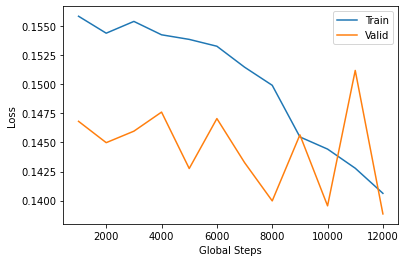

In [79]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Model loaded from <== ./model/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        79
           0     0.9671    0.9987    0.9826      2323

    accuracy                         0.9659      2402
   macro avg     0.4835    0.4994    0.4913      2402
weighted avg     0.9353    0.9659    0.9503      2402



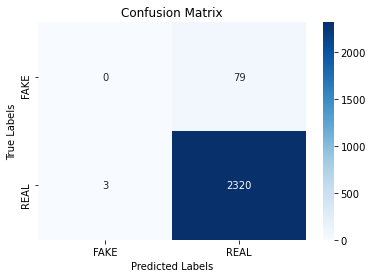

In [80]:
def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(y_batch.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    
    
best_model = MinMaxClassifier(numer_of_features, hidden_size, num_layers, out_size, lr).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
evaluate(best_model, test_loader)

In [44]:
n_epochs = 2000
for epoch in tqdm.tqdm_notebook(range(n_epochs)):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model.train_step(X_batch, y_batch)
#         print(y_pred, y_batch)
    if epoch % 100 != 0: continue
    model.eval()
    with torch.no_grad():
        y_pred = model.forward(X_train)
        train_loss = model.loss(y_pred, y_train)
        y_pred = model.forward(X_test)
        test_loss = model.loss(y_pred, y_test)
    print(f"Epoch {epoch}: train:{train_loss}, test:{test_loss}")

/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


NameError: name 'loader' is not defined

Prediction

In [31]:
X_test, y_test

(tensor([[[12727.],
          [12724.],
          [12728.],
          ...,
          [12719.],
          [12714.],
          [12718.]],
 
         [[12724.],
          [12728.],
          [12725.],
          ...,
          [12714.],
          [12718.],
          [12717.]],
 
         [[12728.],
          [12725.],
          [12722.],
          ...,
          [12718.],
          [12717.],
          [12715.]],
 
         ...,
 
         [[12680.],
          [12675.],
          [12673.],
          ...,
          [12688.],
          [12682.],
          [12687.]],
 
         [[12675.],
          [12673.],
          [12672.],
          ...,
          [12682.],
          [12687.],
          [12678.]],
 
         [[12673.],
          [12672.],
          [12680.],
          ...,
          [12687.],
          [12678.],
          [12678.]]], device='cuda:0'),
 tensor([[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]], device='cuda:0'))

In [32]:
with torch.no_grad():
    y_pred = model(X_test)

In [33]:
y_pred

tensor([[[102.1816],
         [ 96.9199],
         [ 96.1134],
         ...,
         [ 95.9849],
         [ 95.9849],
         [ 95.9849]],

        [[102.1816],
         [ 96.9199],
         [ 96.1134],
         ...,
         [ 95.9849],
         [ 95.9849],
         [ 95.9849]],

        [[102.1816],
         [ 96.9199],
         [ 96.1134],
         ...,
         [ 95.9849],
         [ 95.9849],
         [ 95.9849]],

        ...,

        [[102.1816],
         [ 96.9199],
         [ 96.1134],
         ...,
         [ 95.9849],
         [ 95.9849],
         [ 95.9849]],

        [[102.1816],
         [ 96.9199],
         [ 96.1134],
         ...,
         [ 95.9849],
         [ 95.9849],
         [ 95.9849]],

        [[102.1816],
         [ 96.9199],
         [ 96.1134],
         ...,
         [ 95.9849],
         [ 95.9849],
         [ 95.9849]]], device='cuda:0')

In [34]:
y_test

tensor([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]], device='cuda:0')

In [ ]:
dfext

In [71]:
df.shape

(11064, 3)

In [70]:
dfext

,0,0.1
0,0,0
1,12140,0
2,12145,0
3,12142,0
4,12140,0
...,...,...
7321,12687,0
7322,12678,0
7323,12678,0
7324,12683,0


In [52]:
df['delta'] = df['VarName2'].diff()
df['prev']  = df['VarName2'].shift(periods=1)
df['return'] = df.delta / df.prev * 1000

In [53]:
df['target'] = 0
df.loc[(df.delta < 0) & (df.delta.shift(periods=1) > 0),'target'] = 1
df.loc[(df.delta > 0) & (df.delta.shift(periods=1) < 0),'target'] = -1

In [54]:
df

,AM,VarName2,VarName3,delta,prev,return,target
0,5/10/2019 12:00:00 AM,"7,779.75",-0.21,NaN,NaN,NaN,0
1,5/10/2019 2:00:00 AM,"7,815.75",-0.25,36.00,"7,779.75",4.63,0
2,5/10/2019 4:00:00 AM,"7,810.25",-0.26,-5.50,"7,815.75",-0.70,1
3,5/10/2019 6:00:00 AM,"7,816.25",-0.24,6.00,"7,810.25",0.77,-1
4,5/10/2019 8:00:00 AM,"7,785.75",-0.50,-30.50,"7,816.25",-3.90,1
...,...,...,...,...,...,...,...
11059,2/28/2023 10:00:00 PM,"12,055.00",-0.97,54.00,"12,001.00",4.50,-1
11060,3/1/2023 12:00:00 AM,"12,071.00",-0.88,16.00,"12,055.00",1.33,0
11061,3/1/2023 2:00:00 AM,"12,092.50",-0.65,21.50,"12,071.00",1.78,0
11062,3/1/2023 4:00:00 AM,"12,106.75",-0.36,14.25,"12,092.50",1.18,0


In [11]:
# Create a rolling window of 15 data points
rolling_window = df['VarName2'].rolling(window=15)

In [12]:
rolling_window

Rolling [window=15,center=False,axis=0]

In [16]:
rolling_window.

AttributeError: 'Rolling' object has no attribute 'values'

In [19]:
 = 

array([7842.25, 7842.25, 7842.25, ...,    0.  ,    0.  ,    0.  ])

In [43]:
# Apply the min and max functions to each window
df['min'] = rolling_window.min()
df['max'] = rolling_window.max()
# df['min'] = np.append(df['min'].to_numpy()[14:], np.array([0]*14))
df['max'] = np.append(df['max'].to_numpy()[14:], np.array([0]*14))
df.fillna(0, inplace=True)
# Analyze the resulting dataframe to identify the local minimum and maximum values
local_minima = df.loc[df['VarName2'] == df['min']]
local_maxima = df.loc[df['VarName2'] == df['max']]


In [47]:
s, e = -150, -15
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df.VarName2[s:e]))
fig.add_trace(go.Scatter(x=df.index, y=df['min'][s:e]))
fig.add_trace(go.Scatter(x=df.index, y=df['max'][s:e]))
fig.show()

In [9]:
# Create a rolling window of 15 data points
rolling_window = df['VarName2'].rolling(window=15)

In [10]:
rolling_window

Rolling [window=15,center=False,axis=0]

In [12]:
# Apply the min and max functions to each window
df['min'] = rolling_window.min()
df['max'] = rolling_window.max()

# Analyze the resulting dataframe to identify the local minimum and maximum values
local_minima = df.loc[df['VarName2'] == df['min']]
local_maxima = df.loc[df['VarName2'] == df['max']]

https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/

https://www.youtube.com/watch?v=RHGiXPuo_pI

https://towardsdatascience.com/lstm-text-classification-using-pytorch-2c6c657f8fc0